<a href="https://colab.research.google.com/github/aryan2107-cloud/100-Day-ML-Challenge-/blob/main/Day12_Data_Pipelines.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Data Pipelines

**Dataset:** Adult Income (Census) — Predict if income > $50k

**What you'll learn:**
- Why pipelines matter (avoiding leakage, reproducibility)
- `Pipeline` — chain preprocessing + model
- `ColumnTransformer` — different preprocessing for different columns
- `FeatureUnion` — combine multiple feature paths
- Custom transformers — your own preprocessing steps
- Saving and loading pipelines

**Goal:** Build one clean pipeline that handles everything from raw data to predictions.

---

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler, MinMaxScaler, OneHotEncoder, OrdinalEncoder, LabelEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

import joblib
import warnings
warnings.filterwarnings('ignore')

plt.style.use('seaborn-v0_8-whitegrid')
print('Setup complete!')

Setup complete!


In [4]:
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data"

columns = [
    'age', 'workclass', 'fnlwgt', 'education', 'education_num',
    'marital_status', 'occupation', 'relationship', 'race', 'sex',
    'capital_gain', 'capital_loss', 'hours_per_week', 'native_country', 'income'
]

df = pd.read_csv(url, names=columns, na_values='?', skipinitialspace=True)

print(f"Dataset: {df.shape[0]:,} samples, {df.shape[1]} columns")
df.head()

Dataset: 32,561 samples, 15 columns


,age,workclass,fnlwgt,education,education_num,marital_status,occupation,relationship,race,sex,capital_gain,capital_loss,hours_per_week,native_country,income
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K


In [5]:
# Data overview
print("Column Types:")
print("="*50)
print(df.dtypes)

print(f"\nMissing Values:")
print(df.isnull().sum()[df.isnull().sum() > 0])

Column Types:
age                int64
workclass         object
fnlwgt             int64
education         object
education_num      int64
marital_status    object
occupation        object
relationship      object
race              object
sex               object
capital_gain       int64
capital_loss       int64
hours_per_week     int64
native_country    object
income            object
dtype: object

Missing Values:
workclass         1836
occupation        1843
native_country     583
dtype: int64


In [6]:
# Target distribution
print("\nTarget Distribution:")
print(df['income'].value_counts())
print(f"\n>50k rate: {(df['income'] == '>50K').mean():.1%}")


Target Distribution:
income
<=50K    24720
>50K      7841
Name: count, dtype: int64

>50k rate: 24.1%


Pipelines:

Pipelines bundle all preprocessing steps together:
- No data leakage (fit only on training data)
- Reproducible (same steps every time)
- Clean code (one object does everything)
- Easy deployment (save and load entire workflow)

In [11]:
#identify column types
numeric_features = ['age', 'fnlwgt', 'education_num', 'capital_gain', 'capital_loss', 'hours_per_week']
categorical_features = ['workclass', 'education', 'marital_status', 'occupation', 'relationship', 'race', 'sex', 'native_country']

print(f"Numeric Features: {len(numeric_features)}: {numeric_features}")
print(f"Categorical Features: {len(categorical_features)}: {categorical_features}")

Numeric Features: 6: ['age', 'fnlwgt', 'education_num', 'capital_gain', 'capital_loss', 'hours_per_week']
Categorical Features: 8: ['workclass', 'education', 'marital_status', 'occupation', 'relationship', 'race', 'sex', 'native_country']


In [31]:
#train/test split
x = df.drop('income', axis=1)
y = (df['income'] == '>50K').astype(int) # Corrected '>50k' to '>50K'

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42, stratify=y)

print(f'Training set: {x_train.shape[0]:,} samples')
print(f'Testing set: {x_test.shape[0]:,} samples')

Training set: 26,048 samples
Testing set: 6,513 samples


A Basic Pipeline

In [13]:
numeric_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

print("Numeric Pipeline:")
print(numeric_pipeline)

Numeric Pipeline:
Pipeline(steps=[('imputer', SimpleImputer(strategy='median')),
                ('scaler', StandardScaler())])


In [14]:
#Testing it on numeric columns
x_train_numeric = numeric_pipeline.fit_transform(x_train[numeric_features])
x_test_numeric = numeric_pipeline.transform(x_test[numeric_features])

print(f"Transformed shape: {x_train_numeric.shape}")
print(f"Mean: {x_train_numeric.mean():.2f}")
print(f"Standard Deviation: {x_train_numeric.std():.2f}")


Transformed shape: (26048, 6)
Mean: 0.00
Standard Deviation: 1.00


In [15]:
#Categorical Pipeline
categorical_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('encoder', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
])

print("Categorical Pipeline:")
print(categorical_pipeline)


Categorical Pipeline:
Pipeline(steps=[('imputer',
                 SimpleImputer(fill_value='missing', strategy='constant')),
                ('encoder',
                 OneHotEncoder(handle_unknown='ignore', sparse_output=False))])


In [17]:
#Test it
x_train_cat = categorical_pipeline.fit_transform(x_train[categorical_features])
x_test_cat = categorical_pipeline.transform(x_test[categorical_features])

print(f"Original categorical columns: {len(categorical_features)}")
print(f"Transformed shape(after One-hot): {x_train_cat.shape[1]}")

Original categorical columns: 8
Transformed shape(after One-hot): 102


#ColumnTransformation

Different preprocessing for different columns. It applies different pipelines to different columns

In [20]:
preprocessor = ColumnTransformer(
    transformers = [
        ('num', numeric_pipeline, numeric_features),
        ('cat', categorical_pipeline, categorical_features)
    ],
    remainder = 'drop' #to drop any columns that are not specified
)

print('ColumnTransformer:')
print(preprocessor)
#

ColumnTransformer:
ColumnTransformer(transformers=[('num',
                                 Pipeline(steps=[('imputer',
                                                  SimpleImputer(strategy='median')),
                                                 ('scaler', StandardScaler())]),
                                 ['age', 'fnlwgt', 'education_num',
                                  'capital_gain', 'capital_loss',
                                  'hours_per_week']),
                                ('cat',
                                 Pipeline(steps=[('imputer',
                                                  SimpleImputer(fill_value='missing',
                                                                strategy='constant')),
                                                 ('encoder',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse_output=False))]),
             

In [23]:
#Fit and transform
x_train_processed = preprocessor.fit_transform(x_train)
x_test_processed = preprocessor.transform(x_test)

print(f"Original Features: {x_train.shape[1]}")
print(f"Transformed shape: {x_train_processed.shape[1]}")

print(f"\n  - Numeric: {len(numeric_features)} (scaled)")
print(f"  - Categorical: {x_train_processed.shape[1] - len(numeric_features)} (one-hot encoded)")

Original Features: 14
Transformed shape: 108

  - Numeric: 6 (scaled)
  - Categorical: 102 (one-hot encoded)


In [25]:
#defining feature names after transformation
def get_feature_names(column_transformer):
  feature_names = []

  for name, transformer, column in column_transformer.transformers_:
    if name == 'remainder':
      continue
    if hasattr(transformer, 'get_feature_names_out'):
      names = transformer.get_feature_names_out(column)
    else:
      names = column
    feature_names.extend(names)
  return feature_names

feature_names = get_feature_names(preprocessor)
print(f"Total Features: {len(feature_names)}")
print(feature_names)

Total Features: 108
['age', 'fnlwgt', 'education_num', 'capital_gain', 'capital_loss', 'hours_per_week', 'workclass_Federal-gov', 'workclass_Local-gov', 'workclass_Never-worked', 'workclass_Private', 'workclass_Self-emp-inc', 'workclass_Self-emp-not-inc', 'workclass_State-gov', 'workclass_Without-pay', 'workclass_missing', 'education_10th', 'education_11th', 'education_12th', 'education_1st-4th', 'education_5th-6th', 'education_7th-8th', 'education_9th', 'education_Assoc-acdm', 'education_Assoc-voc', 'education_Bachelors', 'education_Doctorate', 'education_HS-grad', 'education_Masters', 'education_Preschool', 'education_Prof-school', 'education_Some-college', 'marital_status_Divorced', 'marital_status_Married-AF-spouse', 'marital_status_Married-civ-spouse', 'marital_status_Married-spouse-absent', 'marital_status_Never-married', 'marital_status_Separated', 'marital_status_Widowed', 'occupation_Adm-clerical', 'occupation_Armed-Forces', 'occupation_Craft-repair', 'occupation_Exec-manageri

A FUll pipeline: Preprocessing + Model

In [27]:
#The right way
full_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression(max_iter=1000, random_state=42))
])

print("Full Pipeline:")
print(full_pipeline)
#

Full Pipeline:
Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['age', 'fnlwgt',
                                                   'education_num',
                                                   'capital_gain',
                                                   'capital_loss',
                                                   'hours_per_week']),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleI

In [32]:
#Train with one line
full_pipeline.fit(x_train, y_train)

#Predict with one line
y_pred = full_pipeline.predict(x_test)

#Evaluate
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.2%}")
print(f"Classification Report:")
print(classification_report(y_test, y_pred, target_names=['<=50K', '>50K']))


Accuracy: 85.60%
Classification Report:
              precision    recall  f1-score   support

       <=50K       0.89      0.93      0.91      4945
        >50K       0.74      0.62      0.67      1568

    accuracy                           0.86      6513
   macro avg       0.81      0.78      0.79      6513
weighted avg       0.85      0.86      0.85      6513



In [33]:
#Cross-validation
cv_scores = cross_val_score(full_pipeline, x_train, y_train, cv=5, scoring='accuracy')

print(f"Scores: {cv_scores}")
print(f"Mean Accuracy: {cv_scores.mean():.2%}")

Scores: [0.85201536 0.84702495 0.85950096 0.84699558 0.84891534]
Mean Accuracy: 85.09%


Visualizing the pipeline

In [34]:
from sklearn import set_config

set_config(display='diagram')

full_pipeline

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['age', 'fnlwgt',
                                                   'education_num',
                                                   'capital_gain',
                                                   'capital_loss',
                                                   'hours_per_week']),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(fill_value='missing',
                                                                                 strategy='constant')),
                                                                  ('encoder',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  ['workclass', 'education',
                                                   'marital_status',
                                                   'occupation', 'relationship',
                                                   'race', 'sex',
                                                   'native_country'])])),
                ('classifier',
                 LogisticRegression(max_iter=1000, random_state=42))])

In [36]:
set_config(display='text')


Custom Transformers: Sometimes we will nees preprocessing steps that do not exist in sklearn

In [39]:
#Custom Transformer: create Age Groups
class AgeGroupTransformer(BaseEstimator, TransformerMixin):
  "Transform age into age groups"
  def __init__(self, bins=[0, 25, 35, 50, 65, 100],
               labels=['Young', 'Adult', 'Middle', 'Senior', 'Elderly']):
    self.bins = bins
    self.labels = labels

  def fit(self, x, y=None):
    #Nothing to fit
    return self

  def transform(self, x):
    x = x.copy()
    x['age_group'] = pd.cut(x['age'], bins=self.bins, labels=self.labels)
    return x

#Test it
age_transformer = AgeGroupTransformer()
x_with_age_groups = age_transformer.transform(x_train[['age']])
print("Age Group Distribution")
print(x_with_age_groups['age_group'].value_counts())


Age Group Distribution
age_group
Middle     8982
Adult      6806
Young      5116
Senior     4214
Elderly     930
Name: count, dtype: int64


In [41]:
#Custom transformer: Capital net (gain - loss)
class CapitalNetTransformer(BaseEstimator, TransformerMixin):
  #Create capital gain_net = capital_gain - capital_loss
  def fit(self, x, y=None):
    return self

  def transform(self, x):
    x = x.copy()
    if isinstance(x, pd.DataFrame):
      x['capital_net'] = x['capital_gain'] - x['capital_loss']

    else:
      #Assume array with gain at index 0, loss at index 1
      capital_net = x[:, 0] - x[:, 1]
      x = np.column_stack([x, capital_net])

    return x

#Test it
capital_transformer = CapitalNetTransformer()
x_with_capital = capital_transformer.transform(x_train[['capital_gain', 'capital_loss']])
print("Capital Net Stats:")
print(x_with_capital['capital_net'].describe())

Capital Net Stats:
count    26048.000000
mean       972.656480
std       7323.137462
min      -4356.000000
25%          0.000000
50%          0.000000
75%          0.000000
max      99999.000000
Name: capital_net, dtype: float64


In [42]:
#Custom Transformer: Select specific Transformer
class ColumnSelector(BaseEstimator, TransformerMixin):
  #Selecting specific columns froma df
  def __init__(self, columns):
    self.columns = columns

  def fit(self, x , y=None):
    return self

  def transform(self, x):
    return x[self.columns]

In [45]:
#Custom transformer: Log Transform for skewed features
class LogTransformer(BaseEstimator, TransformerMixin):
  #Apply log1p transformation to specified columns
  def __init__(self, columns):
    self.columns = columns

  def fit(self, x, y=None):
    return self

  def transform(self, x):
    x = x.copy()
    if self.columns:
      for col in self.columns:
        x[col] = np.log1p(x[col])
      else:
        x = np.log1p(x)
      return x
#Test it
log_transformer = LogTransformer(columns=['capital_gain'])
x_log = log_transformer.transform(x_train[['capital_gain']])
print(f"Before log: max={x_train['capital_gain'].max()}")
print(f"After log: max={x_log['capital_gain'].max():.2f}")

Before log: max=99999
After log: max=2.53


Advanced Pipeline with Custom Transformers

In [46]:
#Enhanced numeric pipeline with log transform for skewed columns
numeric_pipeline_v2 = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

#Categorical Pipeline
categorical_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('encoder', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
])

#Enhanced Preprocessor
preprocessor_v2 = ColumnTransformer(
    transformers = [
        ('num', numeric_pipeline_v2, numeric_features),
        ('cat', categorical_pipeline, categorical_features)
    ],
    remainder='drop'
)

print("Enhanced Preprocessor:")
print(preprocessor_v2)


Enhanced Preprocessor:
ColumnTransformer(transformers=[('num',
                                 Pipeline(steps=[('imputer',
                                                  SimpleImputer(strategy='median')),
                                                 ('scaler', StandardScaler())]),
                                 ['age', 'fnlwgt', 'education_num',
                                  'capital_gain', 'capital_loss',
                                  'hours_per_week']),
                                ('cat',
                                 Pipeline(steps=[('imputer',
                                                  SimpleImputer(fill_value='missing',
                                                                strategy='constant')),
                                                 ('encoder',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse_output=False))]),
         

In [48]:
#FUll pipeline with random Forest
full_pipeline_v2 = Pipeline([
    ('preprocessor', preprocessor_v2),
    ('classifier', RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1))
])

full_pipeline_v2.fit(x_train, y_train)

y_pred_v2 = full_pipeline_v2.predict(x_test)
accuracy_v2 = accuracy_score(y_test, y_pred_v2)

print(f"Random Forest Pipeline Accuracy: {accuracy_v2:.1%}")
print(f"Classification Report:")
print(classification_report(y_test, y_pred_v2, target_names=['<=50K', '>50K']))


Random Forest Pipeline Accuracy: 85.9%
Classification Report:
              precision    recall  f1-score   support

       <=50K       0.89      0.93      0.91      4945
        >50K       0.74      0.64      0.69      1568

    accuracy                           0.86      6513
   macro avg       0.82      0.78      0.80      6513
weighted avg       0.85      0.86      0.86      6513



HyperParameter Tuning

In [49]:
#Access pipeline
print("Pipeline Parameters:")
for param in full_pipeline_v2.get_params().keys():
  print(param)

Pipeline Parameters:
memory
steps
transform_input
verbose
preprocessor
classifier
preprocessor__force_int_remainder_cols
preprocessor__n_jobs
preprocessor__remainder
preprocessor__sparse_threshold
preprocessor__transformer_weights
preprocessor__transformers
preprocessor__verbose
preprocessor__verbose_feature_names_out
preprocessor__num
preprocessor__cat
preprocessor__num__memory
preprocessor__num__steps
preprocessor__num__transform_input
preprocessor__num__verbose
preprocessor__num__imputer
preprocessor__num__scaler
preprocessor__num__imputer__add_indicator
preprocessor__num__imputer__copy
preprocessor__num__imputer__fill_value
preprocessor__num__imputer__keep_empty_features
preprocessor__num__imputer__missing_values
preprocessor__num__imputer__strategy
preprocessor__num__scaler__copy
preprocessor__num__scaler__with_mean
preprocessor__num__scaler__with_std
preprocessor__cat__memory
preprocessor__cat__steps
preprocessor__cat__transform_input
preprocessor__cat__verbose
preprocessor__cat_

In [51]:
#Grid search with pipeline (use double underscore to access nested parameters)

param_grid = {
    'preprocessor__num__imputer__strategy': ['mean', 'median'],
    'classifier__n_estimators':[50, 100],
    'classifier__max_depth':[10, 20, None]
}

grid_search = GridSearchCV(
    full_pipeline_v2,
    param_grid,
    cv=3,
    scoring='accuracy',
    n_jobs=1,
    verbose=1
)

grid_search.fit(x_train, y_train)

Fitting 3 folds for each of 12 candidates, totalling 36 fits


GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('num',
                                                                         Pipeline(steps=[('imputer',
                                                                                          SimpleImputer(strategy='median')),
                                                                                         ('scaler',
                                                                                          StandardScaler())]),
                                                                         ['age',
                                                                          'fnlwgt',
                                                                          'education_num',
                                                                          'capital_gain',
                                                              

In [52]:
#Best Parameters
print("Best Parameters:")

for param, value in grid_search.best_params_.items():
  print(f"{param}: {value}")

print(f"\nBest Score: {grid_search.best_score_:.2%}")


Best Parameters:
classifier__max_depth: 20
classifier__n_estimators: 100
preprocessor__num__imputer__strategy: mean

Best Score: 86.11%


In [53]:
#Evaluate best model
best_model = grid_search.best_estimator_
y_pred_best =  best_model.predict(x_test)

print(f"Best Model Accuracy: {accuracy_score(y_test, y_pred_best):.1%}")

Best Model Accuracy: 86.6%


Saving and Loading Pipelines

In [54]:
#Save the pipeline
joblib.dump(best_model, 'income_prediction_pipeline.joblib')
print("Pipeline saved successfully!")

Pipeline saved successfully!


In [57]:
#Load the pipeline
loaded_pipeline = joblib.load('income_prediction_pipeline.joblib')
print("Pipeline loaded")

#Test the loaded pipeline
y_pred_loaded = loaded_pipeline.predict(x_test)
print(f"Loaded Pipeline Accuracy: {accuracy_score(y_test, y_pred_loaded):.1%}")

Pipeline loaded
Loaded Pipeline Accuracy: 86.6%


In [59]:
#Use on completely new model

new_person = pd.DataFrame({
    'age': [45],
    'workclass': ['Private'],
    'fnlwgt': [210000],
    'education': ['Masters'],
    'education_num': [14],
    'marital_status': ['Married-civ-spouse'],
    'occupation': ['Prof-specialty'],
    'relationship': ['Husband'],
    'race': ['White'],
    'sex': ['Male'],
    'capital_gain': [5000],
    'capital_loss': [0],
    'hours_per_week': [45],
    'native_country': ['United-States']
})

#predict with one line
prediction = loaded_pipeline.predict(new_person)
probability = loaded_pipeline.predict_proba(new_person)

print("New Person Prediction")
print(f" Income >$50k: {'Yes' if prediction[0]==1 else 'No'}")
print(f" Probability: {probability[0][1]:.1%}")


New Person Prediction
 Income >$50k: Yes
 Probability: 54.2%


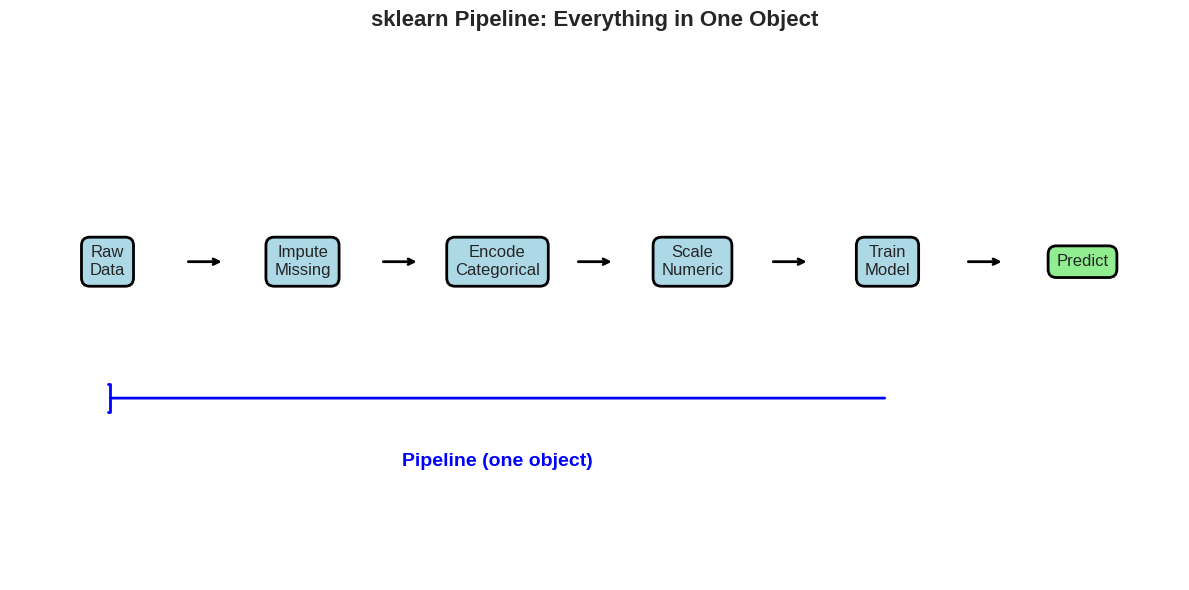

In [60]:
#%%
# Visual summary
fig, ax = plt.subplots(figsize=(12, 6))

# Pipeline flow diagram
steps = ['Raw\nData', 'Impute\nMissing', 'Encode\nCategorical', 'Scale\nNumeric', 'Train\nModel', 'Predict']
x_positions = range(len(steps))

# Draw boxes
for i, (x, step) in enumerate(zip(x_positions, steps)):
    color = 'lightblue' if i < len(steps)-1 else 'lightgreen'
    bbox = dict(boxstyle='round,pad=0.5', facecolor=color, edgecolor='black', linewidth=2)
    ax.text(x, 0.5, step, ha='center', va='center', fontsize=12, bbox=bbox)

    # Draw arrows
    if i < len(steps) - 1:
        ax.annotate('', xy=(x+0.6, 0.5), xytext=(x+0.4, 0.5),
                    arrowprops=dict(arrowstyle='->', color='black', lw=2))

# Pipeline bracket
ax.annotate('', xy=(0, 0.2), xytext=(4, 0.2),
            arrowprops=dict(arrowstyle='-[', color='blue', lw=2))
ax.text(2, 0.05, 'Pipeline (one object)', ha='center', fontsize=14, color='blue', fontweight='bold')

ax.set_xlim(-0.5, 5.5)
ax.set_ylim(-0.2, 1)
ax.axis('off')
ax.set_title('sklearn Pipeline: Everything in One Object', fontsize=16, fontweight='bold')

plt.tight_layout()
plt.show()

## Key Takeaways

### Pipeline Components:

| Component | Purpose | Example |
|-----------|---------|--------|
| `Pipeline` | Chain steps | `Pipeline([('scaler', StandardScaler()), ('model', LogisticRegression())])` |
| `ColumnTransformer` | Different preprocessing per column | Scale numeric, encode categorical |
| `FeatureUnion` | Combine parallel feature paths | Original + PCA features |
| Custom Transformer | Your own preprocessing | Age groups, log transform |

### Benefits:

1. **No data leakage** — fit only on training data
2. **Reproducible** — same steps every time
3. **Clean code** — one object does everything
4. **Easy deployment** — save/load entire workflow
5. **Grid search friendly** — tune all parameters at once

### Key Syntax:

```python
# Access nested parameters with double underscore
pipeline.set_params(preprocessor__num__scaler__with_mean=False)

# Grid search nested parameters
param_grid = {'classifier__n_estimators': [50, 100]}
```



In [61]:
#%%
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [62]:
import os
path = '/content/drive/MyDrive/100-days-of-ml/phase-1-data-foundations/day-12-data-pipelines'
os.makedirs(path, exist_ok=True)

# Save the pipeline
joblib.dump(best_model, f'{path}/income_prediction_pipeline.joblib')

print(f'Folder created: {path}')
print('Pipeline saved!')

Folder created: /content/drive/MyDrive/100-days-of-ml/phase-1-data-foundations/day-12-data-pipelines
Pipeline saved!
